# Jadon Oliver
## 4/23/2024
### Sentiment Analysis of Reviews

## Question: How good is the Chicken Sandwich Scene in Ann Arbor?

### By looking at reviews for chicken sandwiches in Ann Arbor on Yelp, using sentiment analysis, we can see if generally people have a positive or negative opinion on the chicken sandwiches in Ann Arbor, Michigan.

### Import code and yelp api import code

In [6]:
import requests

import yelpkeys # file where client_id and api_key is defined with user's private app information
import nltk
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
APIKEY = yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

### Yelp Fusion API code

In [8]:
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to https://docs.developer.yelp.com/docs/get-started for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= yelpkeys.api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'Chicken Sandwich'
DEFAULT_LOCATION = 'Ann Arbor, MI'
SEARCH_LIMIT = 20


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

### gets response from website with the wanted information

In [9]:
response = search(API_KEY,DEFAULT_TERM, 'Ann Arbor, MI')

Querying https://api.yelp.com/v3/businesses/search ...


### prints response

In [10]:
response

{'businesses': [{'id': 'ZzpqFHVuTnnKpUoYkCyL1A',
   'alias': 'fat-daddy-s-hot-chicken-and-waffles-ann-arbor',
   'name': 'Fat Daddy’s Hot Chicken & Waffles',
   'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/NYSEJGsYxttIWLZRR5Fpww/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/fat-daddy-s-hot-chicken-and-waffles-ann-arbor?adjust_creative=istl9jgw2i0Hp64EIdomvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=istl9jgw2i0Hp64EIdomvQ',
   'review_count': 25,
   'categories': [{'alias': 'chickenshop', 'title': 'Chicken Shop'}],
   'rating': 4.0,
   'coordinates': {'latitude': 42.28062656787318,
    'longitude': -83.74347805276395},
   'transactions': ['delivery', 'pickup'],
   'location': {'address1': '411 E Washington St',
    'address2': '',
    'address3': None,
    'city': 'Ann Arbor',
    'zip_code': '48104',
    'country': 'US',
    'state': 'MI',
    'display_address': ['411 E Washington St', 'Ann Arbor, MI 48104']},
   'phone': '',
  

### Goes through all of the reviews from the response and provides business name, rating, review count, and 3(the maximum) reviews as well as the sentiment analysis through textblob on said review.

In [11]:
for business in response['businesses']:
    print('Business Name: ' + business['name'])
    print('Rating: ' + str(business['rating']))
    print('Review Count: ' + str(business['review_count']))
    print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        print(' - ' + review['text'])
        # Perform sentiment analysis on the review using TextBlob
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            print('    Sentiment: Positive')
        elif sentiment < 0:
            print('    Sentiment: Negative')
        else:
            print('    Sentiment: Neutral')
        print('\n================\n\n\n')

Business Name: Fat Daddy’s Hot Chicken & Waffles
Rating: 4.0
Review Count: 25
Reviews: 
Querying https://api.yelp.com/v3/businesses/ZzpqFHVuTnnKpUoYkCyL1A/reviews ...
 - The chicken and waffles at this place are so good. They have improved the waffles from last time I was here. The chicken was cooked perfect, moist and...
    Sentiment: Positive




 - The storefront doesn't do this place justice! I was planning to have lunch next door but found a very long line waiting for me. Thankfully we saw this spot...
    Sentiment: Negative




 - Truly love this chicken sandwiches! Perfect levels of spice and crispiness. Service is always super quick and friendly.  Portions are huge so I usually get...
    Sentiment: Positive




Business Name: Blazin Coop
Rating: 4.6
Review Count: 9
Reviews: 
Querying https://api.yelp.com/v3/businesses/bNEj949c6xxIdxDIi4-9Qg/reviews ...
 - I LOVE NEW SMALL BUSINESSES. 

Blazin Coop blessed my eyes when I was driving around and looking for food with a few frie

### downloads the stop words and sets them to variab

In [12]:
# Download NLTK resources
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmaol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### sets english stopwords

In [13]:
#sets english stopwords
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### Goes through each review and does textblob and Naivebeys

In [14]:
# Perform sentiment analysis with TextBlob and NaiveBayesAnalyzer
positive_textblob, negative_textblob, neutral_textblob = 0, 0, 0
positive_naive_bayes, negative_naive_bayes, neutral_naive_bayes = 0, 0, 0

wordsc = []
# Loop through each business in the response
for business in response['businesses']:
    reviews = request(API_HOST, '/v3/businesses/{}/reviews'.format(business['id']), API_KEY)
    for review in reviews['reviews']:
        # Perform stopword removal
        processed_review = [word for word in TextBlob(review['text']).words if word.lower() not in stops]
        wordsc.append(' '.join(processed_review))
        # Sentiment analysis with TextBlob
        sentiment_tb = TextBlob(' '.join(processed_review)).sentiment.polarity
        if sentiment_tb > 0:
            positive_textblob += 1
        elif sentiment_tb < 0:
            negative_textblob += 1
        else:
            neutral_textblob += 1
        
        # Sentiment analysis with NaiveBayesAnalyzer
        sentiment_nb = TextBlob(' '.join(processed_review), analyzer=NaiveBayesAnalyzer()).sentiment.classification
        if sentiment_nb == 'pos':
            positive_naive_bayes += 1
        elif sentiment_nb == 'neg':
            negative_naive_bayes += 1
        else:
            neutral_naive_bayes += 1
            
print (positive_textblob)

Querying https://api.yelp.com/v3/businesses/ZzpqFHVuTnnKpUoYkCyL1A/reviews ...
Querying https://api.yelp.com/v3/businesses/bNEj949c6xxIdxDIi4-9Qg/reviews ...
Querying https://api.yelp.com/v3/businesses/8DP6HU2O9u7dIaYuqKGIig/reviews ...
Querying https://api.yelp.com/v3/businesses/N-P5dPjMepH-Ce5b7q8HKQ/reviews ...
Querying https://api.yelp.com/v3/businesses/tRRg6-Qb6kkPyrZ0vdfI7w/reviews ...
Querying https://api.yelp.com/v3/businesses/uTMqhmpgfpDMLN3W3YvMeQ/reviews ...
Querying https://api.yelp.com/v3/businesses/GQjBFoRWJ_Mlsrk4a4XyHw/reviews ...
Querying https://api.yelp.com/v3/businesses/B-Hh0qSJlRvg3YijPR0Ckw/reviews ...
Querying https://api.yelp.com/v3/businesses/KYyE70sn9JE-Gw-dUcbBKQ/reviews ...
Querying https://api.yelp.com/v3/businesses/39qK4WYI7NRBojsdllqRkQ/reviews ...
Querying https://api.yelp.com/v3/businesses/TC6ZUhZqIxRe8pwTusUAjQ/reviews ...
Querying https://api.yelp.com/v3/businesses/VKSttQeK0NmP5n-3T-jX-A/reviews ...
Querying https://api.yelp.com/v3/businesses/DqKnaIcl

In [15]:
print (positive_textblob)
print (negative_textblob)
print (neutral_textblob)
print (positive_naive_bayes)
print (negative_naive_bayes)
print (neutral_naive_bayes)

50
9
1
44
16
0


### Paint TextBlob Donut chart

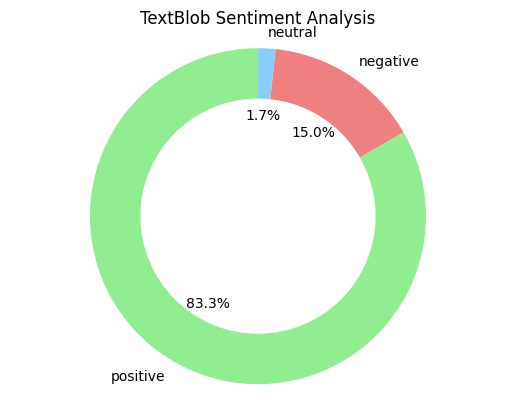

In [16]:
# Plot donut chart for TextBlob sentiment analysis
labels = list(["positive", "negative", "neutral"])
sizes = list([positive_textblob, negative_textblob, neutral_textblob])

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'lightskyblue'], wedgeprops={'width': 0.4})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a circle at the center to transform the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title('TextBlob Sentiment Analysis')

plt.show()


### Print NaveBayes Donut Graph

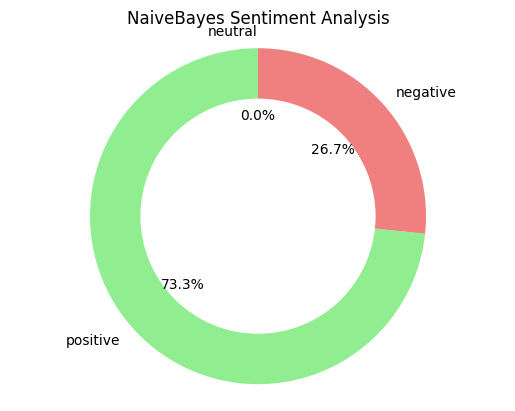

In [17]:
# Plot donut chart for NaiveBayes sentiment analysis
labels = list(["positive", "negative", "neutral"])
sizes = list([positive_naive_bayes, negative_naive_bayes, neutral_naive_bayes])

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral', 'lightskyblue'], wedgeprops={'width': 0.4})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a circle at the center to transform the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title('NaiveBayes Sentiment Analysis')

plt.show()


## Looking at the analysis of the graphs, Michigan overall has a really good presence of great tasting chicken sandwiches and people generally have a positive opinion on them. TextBlob had neutral sentiments while NaiveBayes didn't Naive Bayes also had more negative opinions than TextBlob

### Word Cloud of the top 20 words

['chicken waffles place good improved waffles last time chicken cooked perfect moist', "storefront n't place justice planning lunch next door found long line waiting Thankfully saw spot", 'Truly love chicken sandwiches Perfect levels spice crispiness Service always super quick friendly Portions huge usually get', 'LOVE NEW SMALL BUSINESSES Blazin Coop blessed eyes driving around looking food friends decided give truck', 'ordered online pick food truck currently located auto repair/gas station parking lot location placement strange', "perfect Sunday afternoon stop 'm south n't sure chicken would live expectations Chicken", 'way Michigan State University son stopped Burger One bite great little place lot options choose', 'Solid burger Juicy patty Cheese sauce good Bun needs grilled toasted Fries solid Worth try', "Amazing food recent go place 're town child 's U appt Workers friendly", 'food good Amanda E provided terrible service waited patiently watching service every table around payi

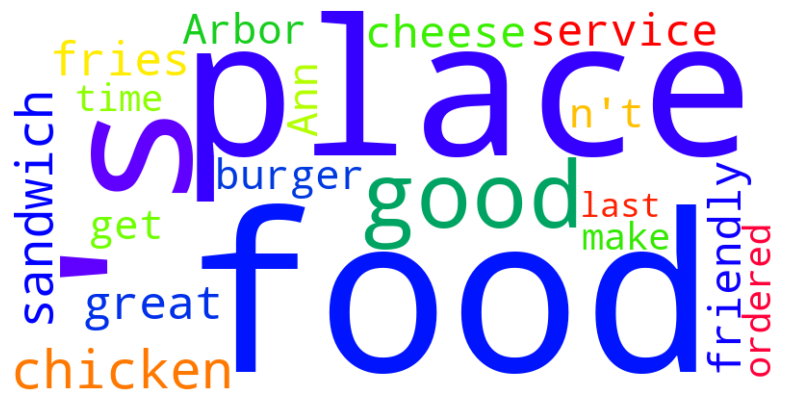

In [18]:
def generate_wordcloud(review_texts):
    words = ' '.join(review_texts)
    wordFreq = Counter(words.split())
    wordsc = WordCloud(width=800, height=400, background_color='white', colormap='prism', max_words=20)
    wordsc.generate_from_frequencies(wordFreq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordsc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate the word cloud
print(wordsc)
generate_wordcloud(wordsc)